In [22]:
# Ben Hawks, z1849064, CSCI480 - Applied Machine Learning, Spring 2020
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl


#make our data easier to use by applying column names to the data istelf w/ names=data_cols
data_cols = ["MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK",
             "MGODPR","MGODOV","MGODGE","MRELGE","MRELSA","MRELOV","MFALLEEN",
             "MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG","MBERHOOG",
             "MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA",
             "MSKB1","MSKB2","MSKC","MSKD","MHHUUR","MHKOOP","MAUT1","MAUT2"
             ,"MAUT0","MZFONDS","MZPART","MINKM30","MINK3045","MINK4575",
             "MINK7512","MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR",
             "PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT","PAANHANG",
             "PTRACTOR","PWERKT","PBROM","PLEVEN","PPERSONG","PGEZONG",
             "PWAOREG","PBRAND","PZEILPL","PPLEZIER","PFIETS","PINBOED",
             "PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT",
             "AMOTSCO","AVRAAUT","AAANHANG","ATRACTOR","AWERKT","ABROM",
             "ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND","AZEILPL",
             "APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"]

cat_cols = ["MOSHOOFD","MOSTYPE" ] 
                      #only categorical data types, needs to be one-hot-encoded, 
                      #otherwise others are discrete, ordinal (already encoded),
                      #or continuous, or can be treated as such

train_data_url='http://kdd.ics.uci.edu/databases/tic/ticdata2000.txt'
train_data = pd.read_csv(train_data_url,na_values="",keep_default_na=False,delimiter="\t",names=data_cols)
train_data_X = train_data.drop('CARAVAN',1)
train_data_Y = train_data.CARAVAN


test_data_url='http://kdd.ics.uci.edu/databases/tic/ticeval2000.txt'
test_data = pd.read_csv(test_data_url,na_values="",keep_default_na=False,delimiter="\t",names=data_cols)
test_data = test_data.drop('CARAVAN',1)

test_targets_url='http://kdd.ics.uci.edu/databases/tic/tictgts2000.txt'
test_targets = pd.read_csv(test_targets_url,na_values="",keep_default_na=False,delimiter="\t",names=["CARAVAN"])



train_data.describe()



,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.00000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,0.883545,2.290450,1.887667,3.230333,4.300240,1.461010,3.351254,4.572484,1.895053,0.397973,0.522329,2.899004,2.219856,2.306424,1.620749,1.606836,2.202508,3.758674,1.067331,4.236860,4.771728,6.040364,1.316386,1.959464,6.277053,2.728959,2.573686,3.536070,2.731364,0.796118,...,2.970457,0.048265,0.175369,0.009447,0.020955,0.092580,0.013054,0.215046,0.194778,0.013741,0.015287,0.023531,1.827722,0.000859,0.018894,0.025249,0.01563,0.047578,0.402954,0.014772,0.020611,0.562178,0.010477,0.041051,0.002233,0.012539,0.033665,0.006183,0.070423,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256,0.059773
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,0.965924,1.722645,1.799928,1.619973,2.005283,1.622967,1.761052,2.298125,1.798321,0.775073,1.056926,1.839675,1.730840,1.692843,1.722882,1.330664,1.529319,1.935568,1.303175,3.089302,3.089837,1.552799,1.203072,1.599714,1.978675,1.981893,2.086099,1.882656,1.927738,1.162829,...,2.920669,0.531346,0.897222,0.244675,0.212738,0.603076,0.228906,0.813133,0.898100,0.209260,0.192471,0.375274,1.879290,0.043462,0.273028,0.156894,0.20456,0.409016,0.492631,0.134133,0.142092,0.604767,0.129991,0.228974,0.062819,0.125775,0.240755,0.124189,0.265112,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996,0.237087
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1

In [0]:
test_data.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.253000,1.10600,2.675750,3.004000,5.787000,0.706750,4.653250,1.021250,3.269500,6.197000,0.858000,2.281000,1.886750,3.247500,4.30675,1.518750,3.243250,4.620500,1.904250,0.41100,0.579750,2.845250,2.236250,2.269000,1.69425,1.578000,2.208000,3.718250,1.069500,4.116250,4.889000,5.996500,1.364500,1.952750,6.221250,2.782250,2.582000,3.461000,2.751250,0.826500,...,0.076750,2.936000,0.064500,0.164250,0.008000,0.017000,0.095000,0.009250,0.215000,0.213250,0.008250,0.023750,0.023000,1.881000,0.002750,0.010000,0.025500,0.018250,0.042250,0.395750,0.013000,0.022250,0.55000,0.012000,0.039000,0.002250,0.009750,0.035500,0.003750,0.072000,0.084500,0.003500,0.010000,0.00375,0.579750,0.001500,0.003750,0.031000,0.009250,0.013250
std,13.022822,0.42108,0.767306,0.790025,2.899609,1.032241,1.729093,1.001274,1.618958,1.876585,0.956067,1.693297,1.748911,1.593386,1.95323,1.678497,1.665164,2.252942,1.837778,0.80358,1.173876,1.856654,1.772913,1.671029,1.76976,1.307992,1.541373,1.958399,1.291157,3.097682,3.097996,1.530873,1.228421,1.592844,2.031337,2.033069,2.054344,1.854141,1.983647,1.189433,...,0.519063,2.923532,0.613134,0.875765,0.226823,0.182262,0.606273,0.194098,0.807736,0.928434,0.153909,0.241248,0.375508,1.883939,0.072414,0.194704,0.157658,0.221199,0.378815,0.491113,0.113288,0.147514,0.61408,0.129847,0.215617,0.075805,0.100784,0.262215,0.085075,0.270803,0.394206,0.059065,0.099511,0.06113,0.560106,0.038706,0.072369,0.206276,0.095743,0.114358
min,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.00000,2.000000,3.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,2.000000,3.00000,0.000000,2.000000,3.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,0.00000,1.00000

In [0]:

test_targets.describe()

,CARAVAN
count,4000.000000
mean,0.059500
std,0.236588
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


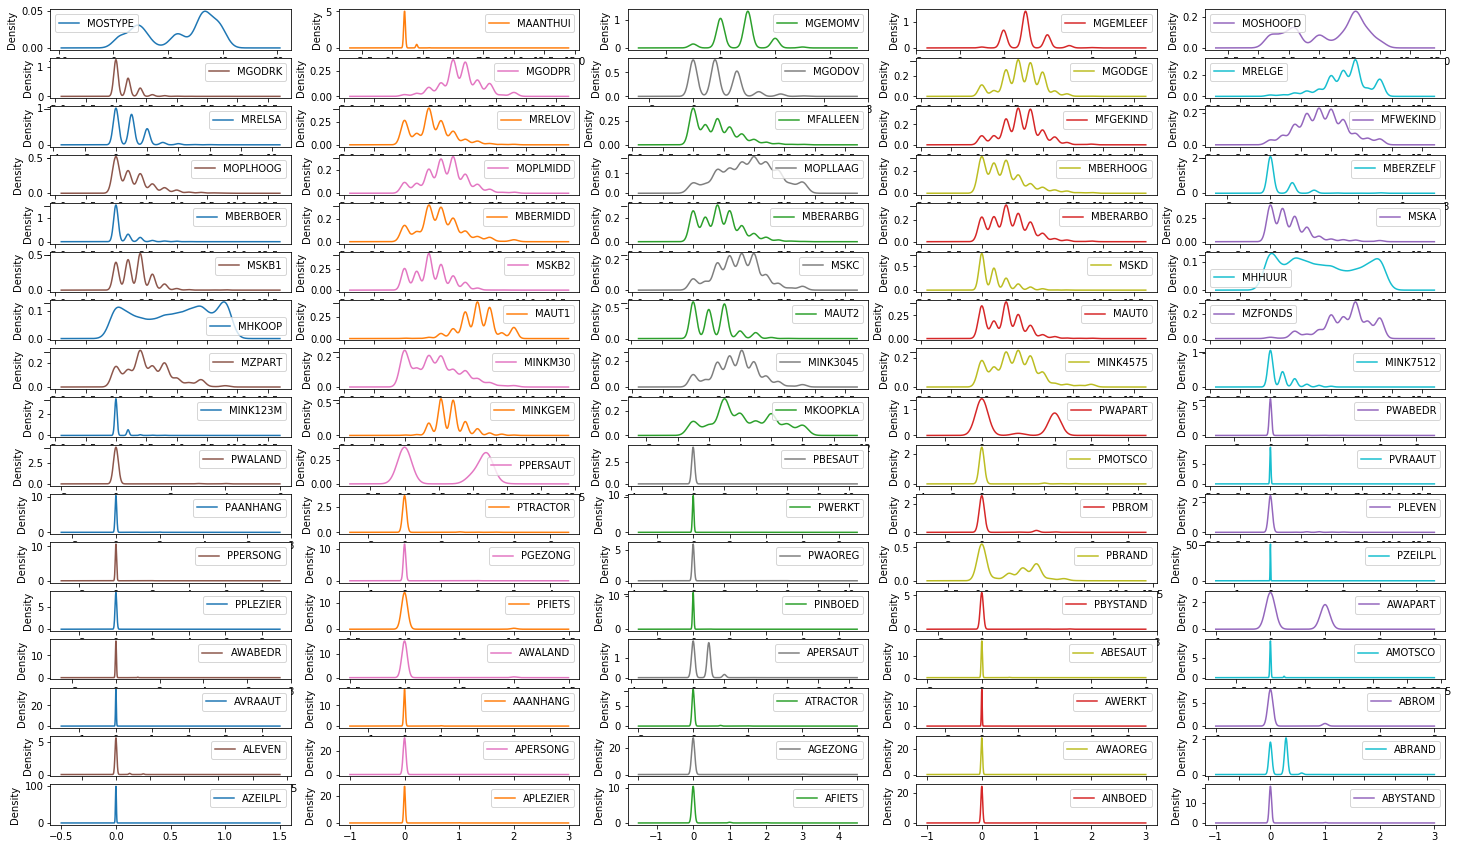

In [0]:
#Density plots through this MAGICAL pandas df.plot operation
train_data_X.plot(kind='density',subplots=True,layout=(17,5),sharex=False,sharey=False,figsize=(25,15))
plt.show()


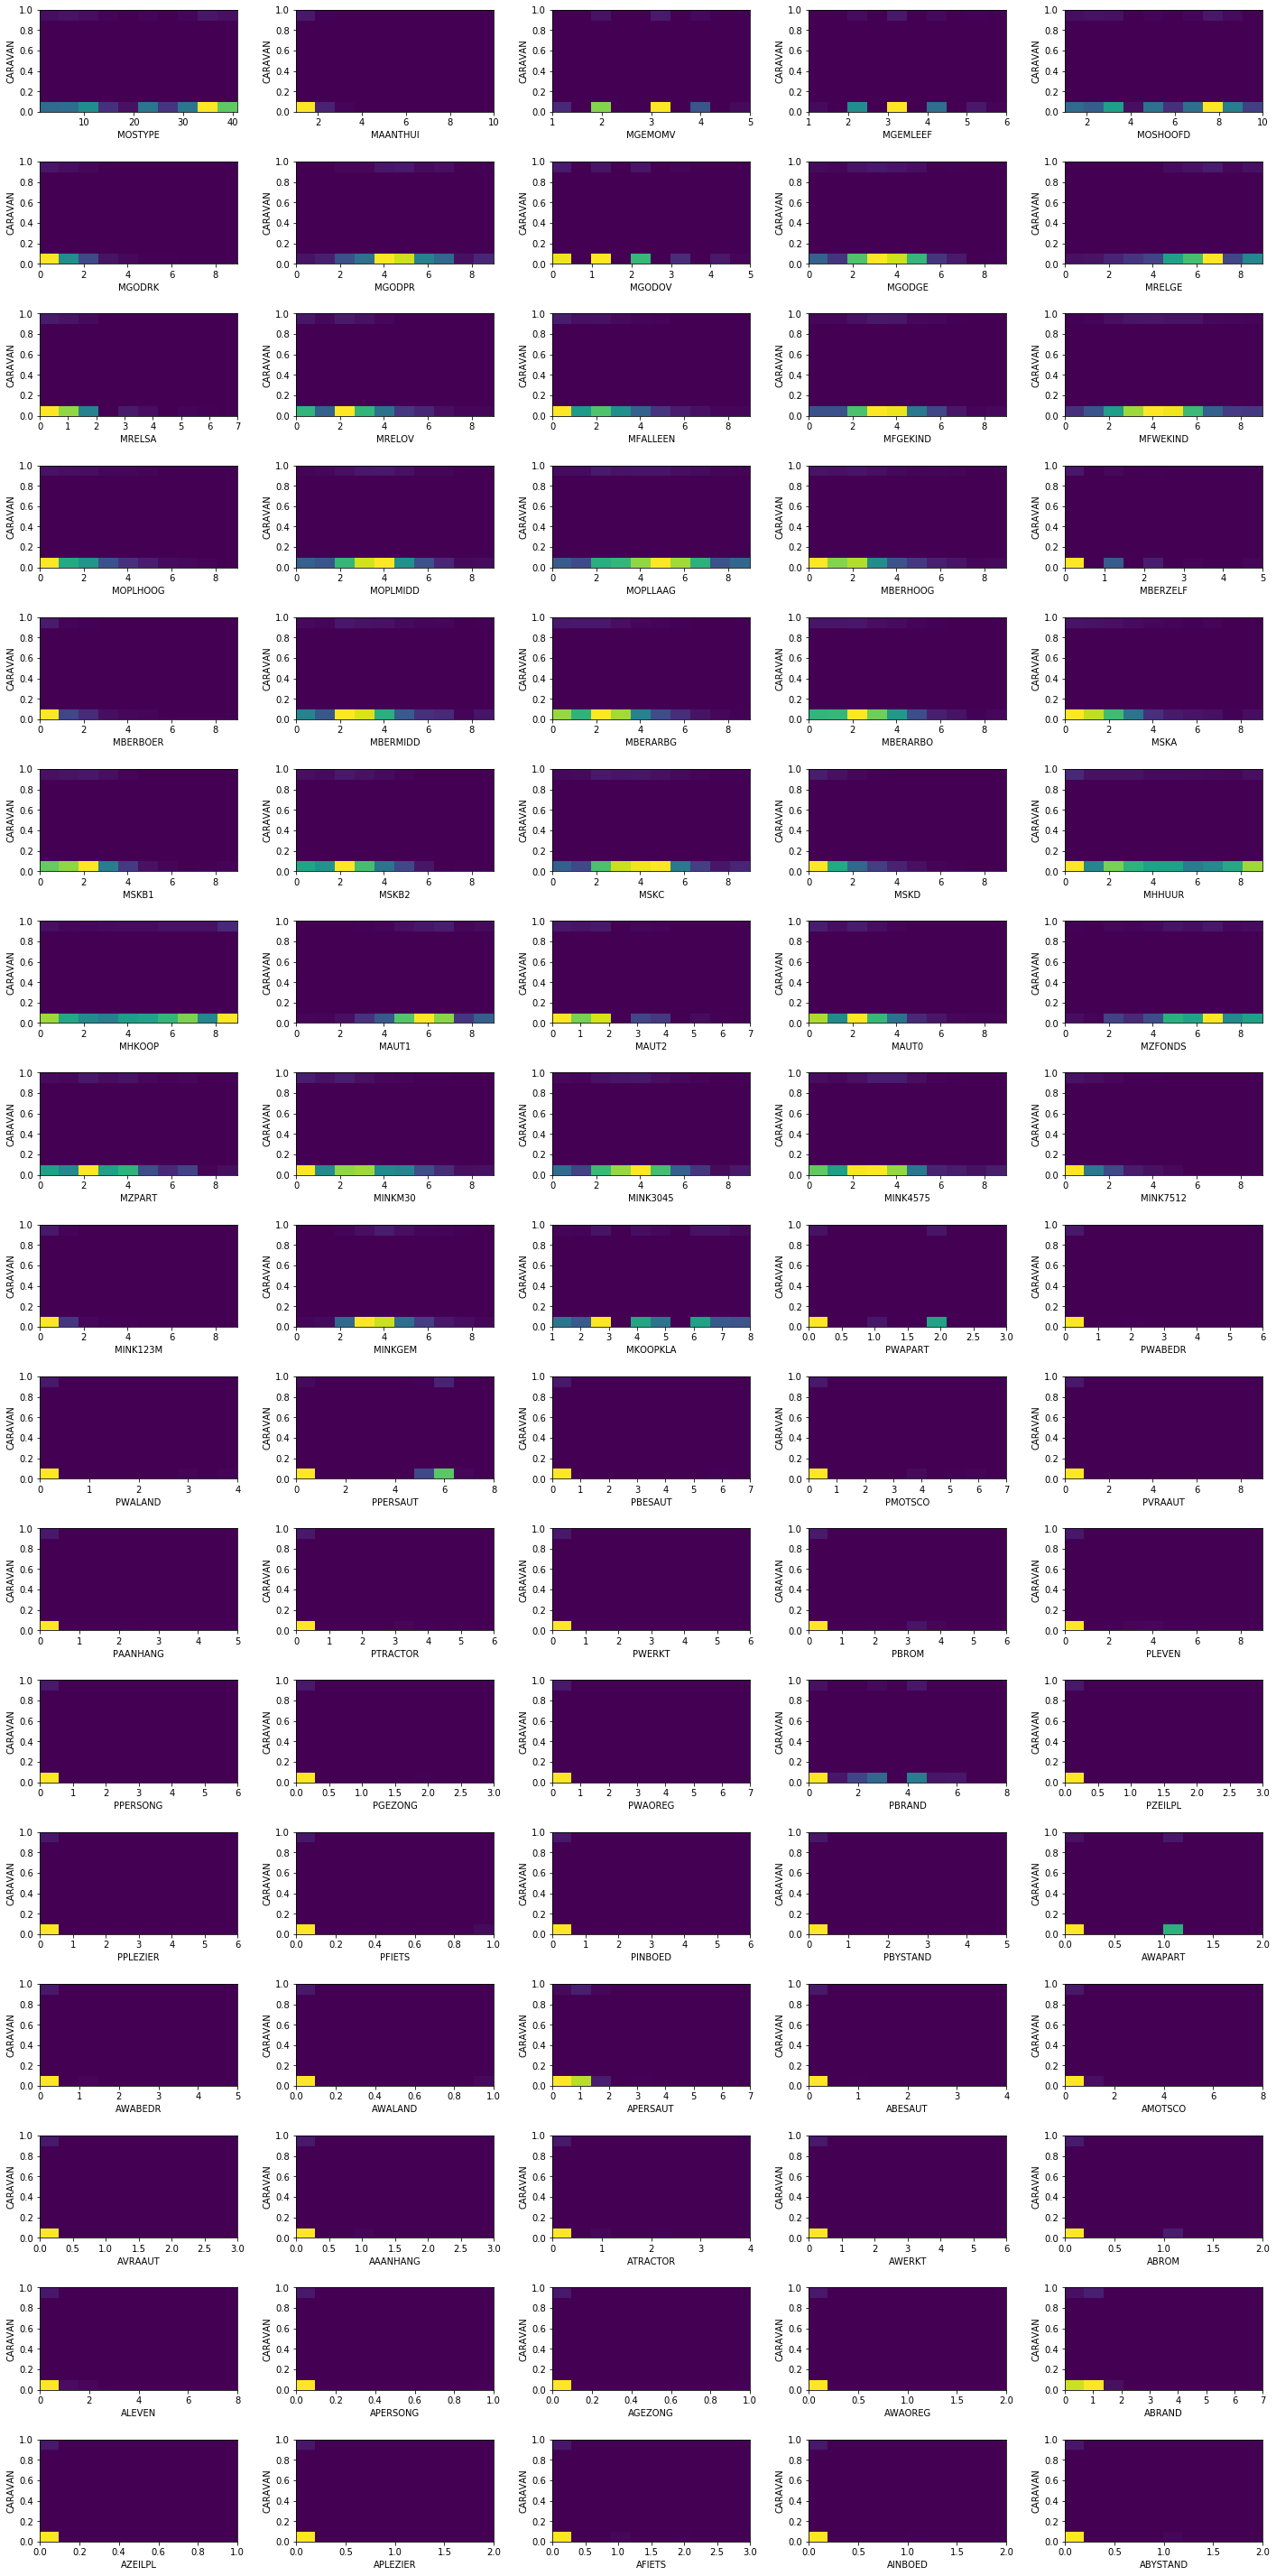

In [2]:
target_fig, target_ax = plt.subplots(17,5,figsize=(20,40),sharey=False, sharex=False) #Feature vs Target
for col in train_data_X.columns:
  crow = data_cols.index(col)//5
  ccol = data_cols.index(col)%5
  target_ax[crow,ccol].hist2d(train_data_X[col],train_data["CARAVAN"])
  target_ax[crow,ccol].set_xlabel(col)
  target_ax[crow,ccol].set_ylabel("CARAVAN")
target_fig.tight_layout(pad=2)
plt.show()


Admitidley I'm a bit unsure of what features to select, and that's likely to do my visualization methods, I found that the most effective method that caputures the relevant data was a 2D Histogram, but this was even unclear to a degree. Scatter plots didn't give a lot of meaninful data, so this was the best solution I found. Given this, If I had to choose 10 features, they'd be:


1.   MOSTYPE
2.   MOOSHOOFD
3.   MGODPR
4.   MGODGE
5.   MRELGE
6.   MFWEKIND
7.   MFGEKIND
8.   MINKGEM
9.   MBERMIDD
10.  MHKOOP


This is mostly due to these values having noticable amounts of policys purchased while also seeming to have some sort of relationship between the distrobution of policy vs no policy


**Part 2: Logistic Regression & Grid searching for best C**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

C = np.array([0.01,0.1,1,10,100,1000]) #A few C values to use, nothing crazy
train_data_x_ohe = pd.get_dummies(train_data_X,columns=cat_cols) #One hot encode our data, both train and test
test_x_ohe = pd.get_dummies(test_data,columns=cat_cols)

In [13]:
logGrid = GridSearchCV(estimator=LogisticRegression(solver='liblinear',penalty='l1'),param_grid={"C":C},scoring='r2') #grid search for the best C 
logGrid.fit(train_data_x_ohe,train_data_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [14]:
print("Best Score: " + str(logGrid.best_score_) + " with C = " + str(logGrid.best_params_))
coef_arr = logGrid.best_estimator_.coef_[0]
count=0
print("Non-Zero Coefficents : ")
for i in range(len(coef_arr)):
  if coef_arr[i] !=0:
    count += 1
    print(train_data_x_ohe.columns[i] + ": "+str(coef_arr[i])) #Print the features with non-zero coefficents and their coefficents
print("Total Non-zero coefs: " + str(count))

Best Score: -0.0635732556427893 with C = {'C': 0.01}
Non-Zero Coefficents : 
MGODGE: -0.02780714728855617
MRELOV: -0.008750237549617988
MOPLMIDD: -0.014851518418524907
MOPLLAAG: -0.1309081786220828
MHHUUR: -0.18034739214528098
MHKOOP: -0.1250844127111124
MZFONDS: -0.14145154469606525
MZPART: -0.12048168906843316
MINKM30: -0.0201685114833399
PPERSAUT: 0.15512627482108818
PBRAND: 0.034214357068226696
Total Non-zero coefs: 11


We got 11 Features here that were non-zero coefficents with a C of 0.01,
Some of the features here were the same as the ones that we selected, such as MGODPR, MFWEKIND, and MRELGE, but the others were not. 

**Part 3: Adding Polynomial Features to the LogReg**

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler


In [0]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(train_data_x_ohe)
x_test_poly = poly.fit_transform(test_x_ohe)


In [0]:
model = LogisticRegressionCV(solver='liblinear',penalty='l1',Cs=[0.01],scoring='r2', verbose=1, cv=10) #use the C value from the previous grid search for time sake
model.fit(x_poly,train_data_Y)

In [21]:
score = model.score(x_test_poly,test_targets)
print("Best Score: " + str(np.mean(score)) + "With params C=0.01")

Best Score: -0.06326422115895802With params C=0.01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


**Part 4 - Different models and optimizing parameters for them**

In [28]:
from sklearn.feature_selection import SelectKBest, chi2

select = SelectKBest(chi2,k=25)
select.fit_transform(train_data_x_ohe,train_data_Y) #returns np.array, would rather work with pandas.df
x_mask = select.get_support()
x_test_new = test_x_ohe

drop_features = []
for i in range(len(x_mask)):
  if not x_mask[i]:
    drop_features.append(test_x_ohe.columns[i])

x_test_new = test_x_ohe.drop(columns=drop_features)
x_new = train_data_x_ohe.drop(columns=drop_features) # do this to preserve data as pandas.df for convience sake

x_new.describe()

,MRELOV,MFALLEEN,MOPLHOOG,MOPLLAAG,MBERHOOG,MBERBOER,MSKA,MSKD,MHHUUR,MHKOOP,MAUT0,MINKM30,MINK7512,MKOOPKLA,PWAPART,PPERSAUT,PBROM,PWAOREG,PBRAND,PPLEZIER,PBYSTAND,APERSAUT,APLEZIER,MOSHOOFD_2,MOSTYPE_8
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,2.290450,1.887667,1.461010,4.572484,1.895053,0.522329,1.620749,1.067331,4.236860,4.771728,1.959464,2.573686,0.796118,4.236345,0.771213,2.970457,0.215046,0.023531,1.827722,0.018894,0.047578,0.562178,0.006012,0.086225,0.058227
std,1.722645,1.799928,1.622967,2.298125,1.798321,1.056926,1.722882,1.303175,3.089302,3.089837,1.599714,2.086099,1.162829,2.007150,0.958623,2.920669,0.813133,0.375274,1.879290,0.273028,0.409016,0.604767,0.081632,0.280720,0.234193
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,5.000000,2.000000,0.000000,1.000000,1.000000,4.000000,5.000000,2.000000,2.000000,0.000000,4.000000,0.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,2.000000,6.000000,3.000000,1.000000,2.000000,2.000000,7.000000,7.000000,3.000000,4.000000,1.000000,6.000000,2.000000,6.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,3.000000,8.000000,6.000000,7.000000,8.000000,6.000000,5.000000,7.000000,2.000000,1.000000,1.000000


In [27]:
x_test_new.describe()

,MRELOV,MFALLEEN,MOPLHOOG,MOPLLAAG,MBERHOOG,MBERBOER,MSKA,MSKD,MHHUUR,MHKOOP,MAUT0,MINKM30,MINK7512,MKOOPKLA,PWAPART,PPERSAUT,PBROM,PWAOREG,PBRAND,PPLEZIER,PBYSTAND,APERSAUT,APLEZIER,MOSHOOFD_2,MOSTYPE_8
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.00000
mean,2.281000,1.886750,1.518750,4.620500,1.904250,0.579750,1.69425,1.069500,4.116250,4.889000,1.952750,2.582000,0.826500,4.295250,0.755750,2.936000,0.215000,0.023000,1.881000,0.010000,0.042250,0.55000,0.003750,0.081250,0.05175
std,1.693297,1.748911,1.678497,2.252942,1.837778,1.173876,1.76976,1.291157,3.097682,3.097996,1.592844,2.054344,1.189433,1.986596,0.953582,2.923532,0.807736,0.375508,1.883939,0.194704,0.378815,0.61408,0.072369,0.273253,0.22155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
50%,2.000000,2.000000,1.000000,5.000000,2.000000,0.000000,1.00000,1.000000,4.000000,5.000000,2.000000,2.000000,0.000000,4.000000,0.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.00000
75%,3.000000,3.000000,2.000000,6.000000,3.000000,1.000000,2.00000,2.000000,7.000000,8.000000,3.000000,4.000000,1.000000,6.000000,2.000000,6.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.00000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,8.000000,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,3.000000,9.000000,6.000000,7.000000,8.000000,5.000000,5.000000,12.00000,2.000000,1.000000,1.00000


In [0]:
from imblearn.over_sampling import ADASYN
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

x_test_new_poly = poly.fit_transform(x_test_new)
x_new_poly = poly.fit_transform(x_new)

ada = ADASYN() #use the fun adatptive Synthetic over sampling algorithm, honestly just to try it out, it seems cool
x_os_new, y_os_new = ada.fit_sample(x_new,train_data_Y)  #dont use polynomials for SVM/Trees at first, try our the perf first without them

In [30]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # Suppress these dataconversionwarnings, no need to worry about converting this data from int64 to float64

scaler_list = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler()]
for scaler in scaler_list: #SVM with multiple scalars, just to see the effects they have
  svc_pipeline = Pipeline(steps=[('scaler', scaler), ('svc', LinearSVC(dual=False))]) #dual false bc n_samples > n_features
  param_grid = {'svc__C': C} #same C's as we've been using
  gridSVM = GridSearchCV(svc_pipeline, param_grid=param_grid, cv=10)
  gridSVM.fit(x_os_new, y_os_new)  #fit to oversampled, reduced feature dataset, no polynomials
  estimator = gridSVM.best_estimator_
  test_score = estimator.score(X=x_test_new, y=test_targets)  #score on reduced feature test dataset
  print("Got best score SVM for scaler " + str(scaler) + "with params " + str(gridSVM.best_params_) + ": " + str(gridSVM.best_score_))
  print("Actual test score: " + str(test_score))

Got best score SVM for scaler StandardScaler(copy=True, with_mean=True, with_std=True)with params {'svc__C': 100.0}: 0.813270055672173
Actual test score: 0.8365
Got best score SVM for scaler RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)with params {'svc__C': 1000.0}: 0.813270055672173
Actual test score: 0.8365
Got best score SVM for scaler MinMaxScaler(copy=True, feature_range=(0, 1))with params {'svc__C': 10.0}: 0.813270055672173
Actual test score: 0.83825
Got best score SVM for scaler MaxAbsScaler(copy=True)with params {'svc__C': 10.0}: 0.813270055672173
Actual test score: 0.839


In [0]:
  tree = DecisionTreeClassifier() #dont need a pipeline, scaling doesnt do anything for trees
  param_grid = {'max_leaf_nodes': range(2,50),
                'max_depth': range(2,10),
                'min_samples_leaf':range(10,261,50)} #10,50,60,...,260
  gridTree = GridSearchCV(tree, param_grid=param_grid, cv=10)
  gridTree.fit(x_os_new, y_os_new) #fit to oversampled, reduced feature dataset
  estimator = gridTree.best_estimator_
  test_score = estimator.score(X=x_test_new, y=test_targets) #score on reduced feature test dataset
  print("Got best score for Tree with params " + str(gridTree.best_params_) + ": " + str(gridTree.best_score_))
  print("Actual test score: " + str(test_score))

Got best score for Tree with params {'max_depth': 9, 'max_leaf_nodes': 49, 'min_samples_leaf': 10}: 0.7637187947871881
Actual test score: 0.699


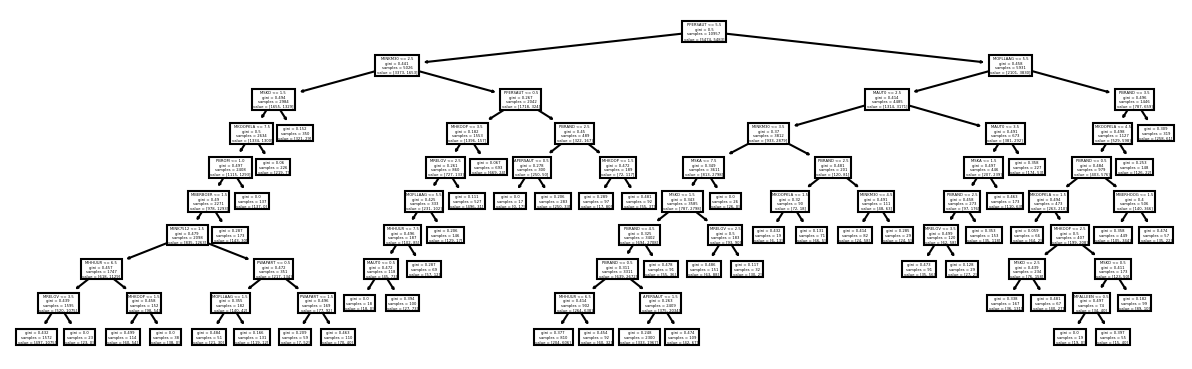

In [0]:
  from sklearn.tree import plot_tree
  plt.figure(figsize=(10, 3), dpi=150)
  tree_dot = plot_tree(gridTree.best_estimator_, feature_names=x_new.columns)  

Seems like all the scalers work (almsost) equally well with the SVC, albeit with different C values. It's somewhat strange but a lot of the data is close to the same scale anyway (seemingly ~1-10), so it seems like this is an effect of the C value and scaler's itneractions finding the same "sweet spot", so not super strange. 

The tree did pretty good, getting an accuracy of ~0.763/0.699 , but still not as good as the SVC. Aside from that, It's incredibly complex, So I'd call the SVC, using any scaler really (MaxAbsScaler by a hair in this case) with the C = 10 the "Best" model with an accuracy of .813/.839 on the test dataset



**Part 5 - Good Explainable Model**

Because trees are inherently easy to explain, I'll continue optimizing the tree for smaller paramters and visualize the curve of different parameters vs accuracy vs the parameters




In [0]:
  ex_tree = DecisionTreeClassifier(min_samples_leaf=50) #We have a lot of samples, 
  #and the grid search is obviously going to like smaller min_sample vals,
  #but putting it at 50 (arbitrarily selected) will make the model a lot less complex
  param_grid = {'max_leaf_nodes': range(2,15), #the less leaf nodes the better, set our search for an upper limit of 10 
                'max_depth': range(2,5)} # 3, 4 and 5 deep trees are easily inspectable, but more than that makes it a bit difficult
  exGridTree = GridSearchCV(ex_tree, param_grid=param_grid, cv=10)
  exGridTree.fit(x_os_new, y_os_new)
  estimator = exGridTree.best_estimator_
  test_score = estimator.score(X=x_test_new, y=test_targets) #score on reduced feature dataset
  print("Got best score for Tree with params " + str(exGridTree.best_params_) + ": " + str(exGridTree.best_score_))
  print("Actual test score: " + str(test_score))

Got best score for Tree with params {'max_depth': 4, 'max_leaf_nodes': 11}: 0.7018365663433657
Actual test score: 0.5685


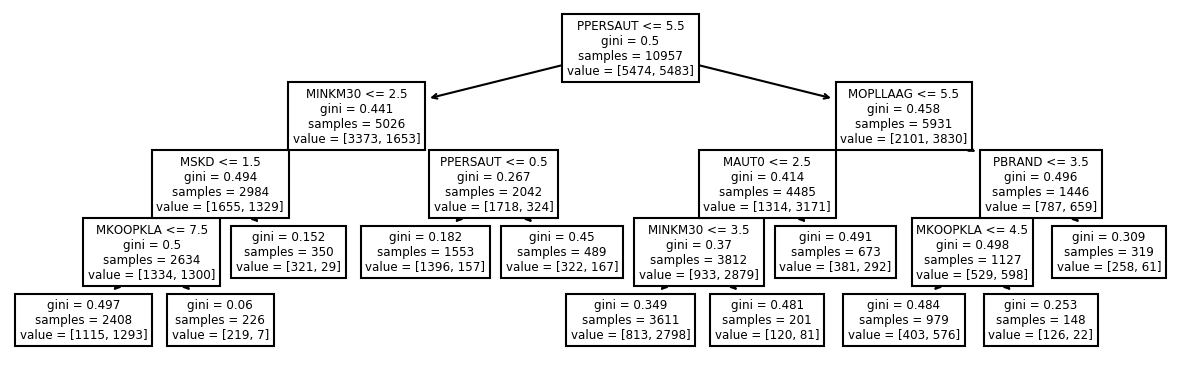

In [0]:
  plt.figure(figsize=(10, 3), dpi=150)
  ex_tree_dot = plot_tree(exGridTree.best_estimator_, feature_names=x_new.columns)  

This didn't do to well on our actual test set, yikes. Lets play around with some things and see if we can't tune it a bit better some more

Got best score for Tree with params {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 6}: 0.684402809719028
Actual test score: 0.73075


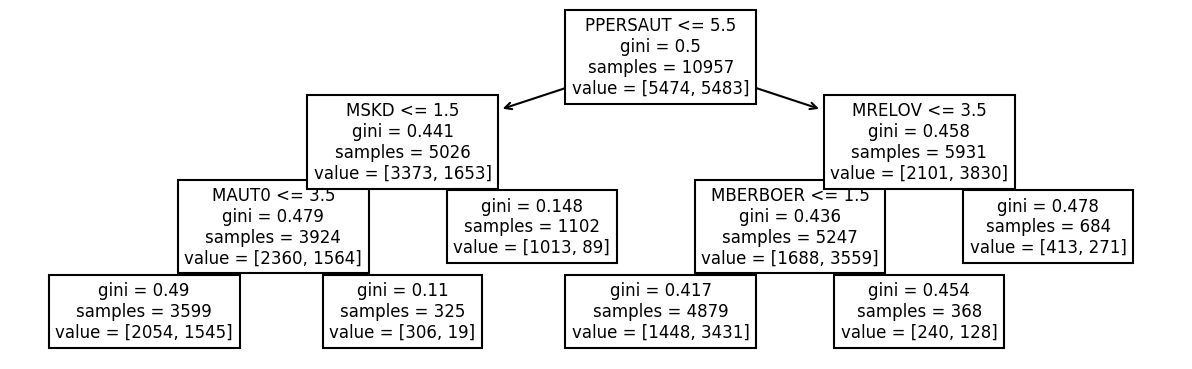

In [0]:
ex_tree = DecisionTreeClassifier(min_samples_leaf=50)
param_grid = {'max_leaf_nodes': range(2,15), #the less leaf nodes the better, set our search for an upper limit of 10 
              'max_depth': range(2,5),
              'max_features': ['sqrt','log2']} #try out limiting max features, see what happenens
exGridTree = GridSearchCV(ex_tree, param_grid=param_grid, cv=10)
exGridTree.fit(x_os_new, y_os_new)
estimator = exGridTree.best_estimator_
test_score = estimator.score(X=x_test_new, y=test_targets) #score on reduced feature dataset
print("Got best score for Tree with params " + str(exGridTree.best_params_) + ": " + str(exGridTree.best_score_))
print("Actual test score: " + str(test_score))
plt.figure(figsize=(10, 3), dpi=150)
ex_tree_dot2 = plot_tree(exGridTree.best_estimator_, feature_names=x_new.columns)  

playing with Max features helped a bit it seems, at least for our actual test data, though it seems to vary based on the random generator that the CV is using to split data, we did manage to get:


> Got best score for Tree with params {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 6}: 0.684402809719028

> Actual test score: 0.73075
![tree-img](https://i.imgur.com/1QvQPJo.png)


Overall, without making the model to complex, this is probably one of the best trees we'd be able to achieve. The score is still ~10-15% off of the SVM's score, but otherwise isn't bad for being so simple.  

